In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score


2024-02-08 19:53:27.495260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_train = pd.read_csv("../Data/train.csv")
df_test = pd.read_csv("../Data/test.csv")

In [121]:
# Download NLTK resources
nltk.download(['stopwords', 'wordnet', 'punkt'])

# Set up NLTK resources
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Function to clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)  # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    html = re.compile(r'<.*?>')
    text = html.sub(r'', text)  # Remove HTML tags
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p, '')  # Remove punctuations
    text = [word.lower() for word in text.split() if word.lower() not in sw]  # Remove stopwords
    text = [lemmatizer.lemmatize(word) for word in text]  # Lemmatize words
    text = " ".join(text)  # Join the words back together
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)  # Remove emojis
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eduardobourget/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/eduardobourget/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eduardobourget/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [122]:
# Function to preprocess the dataset
def preprocess(df):
    df['text'] = df['text'].apply(lambda x: clean_text(x))
    df = df.fillna('NaN', axis=1)
    df['text'] = 'KEYWORD= ' + df.keyword + '; LOCATION= ' + df.location + '; TEXT= ' + df.text
    df.drop(["id", "keyword", "location"], inplace=True, axis=1)
    return df

# Preprocess the training and testing datasets
df_train = preprocess(df_train)
df_test = preprocess(df_test)



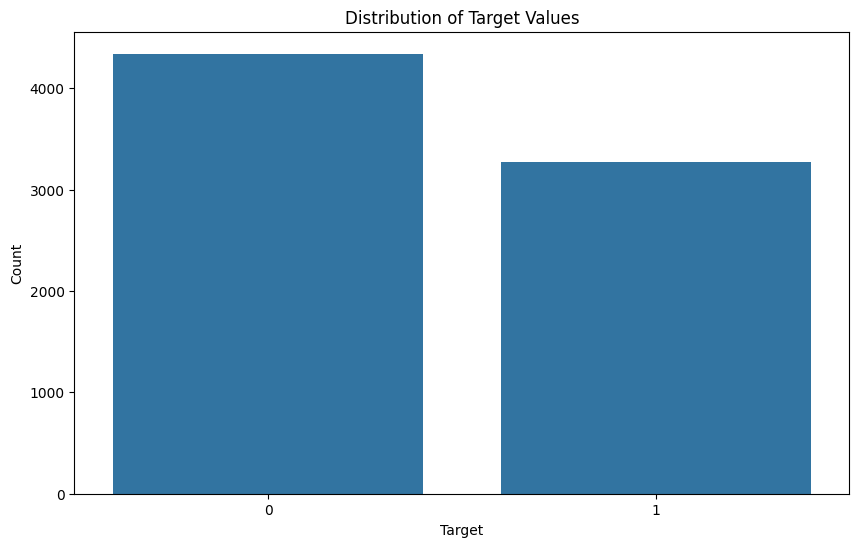

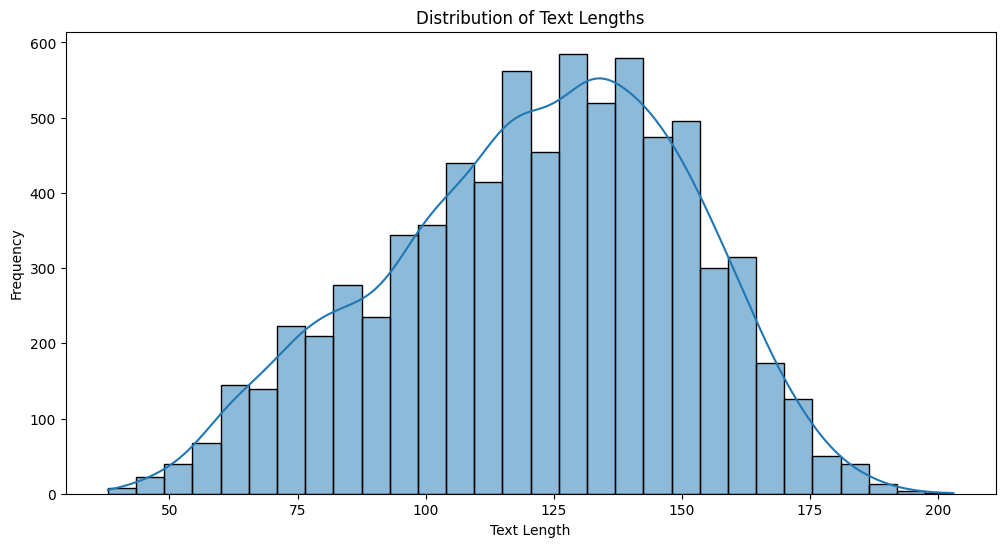

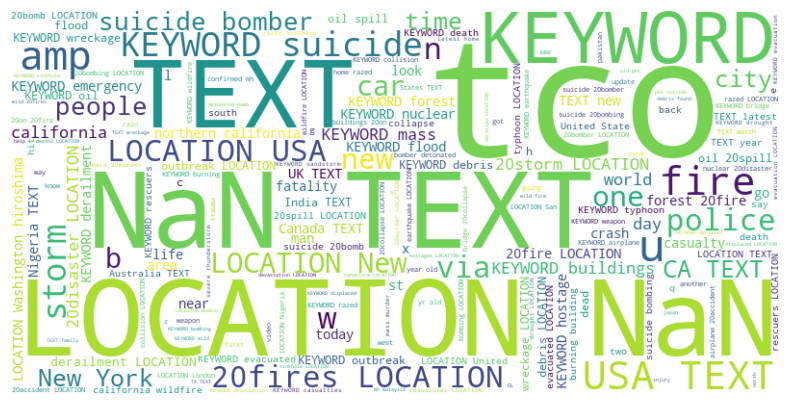

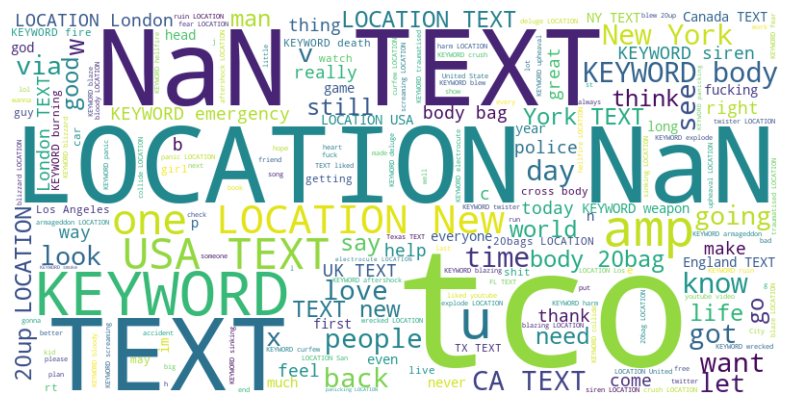

In [123]:
# Visualize the distribution of target values
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df_train)
plt.title('Distribution of Target Values')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Visualize the distribution of text lengths
df_train['text_length'] = df_train['text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df_train['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Visualize the most common words in the dataset
from wordcloud import WordCloud

def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Create a word cloud for disaster tweets
disaster_tweets = df_train[df_train['target'] == 1]['text'].str.cat(sep=' ')
plot_wordcloud(disaster_tweets)

# Create a word cloud for non-disaster tweets
non_disaster_tweets = df_train[df_train['target'] == 0]['text'].str.cat(sep=' ')
plot_wordcloud(non_disaster_tweets)

In [124]:
# Split the dataset into training and validation sets
TRAIN_SPLIT = 0.80
VAL_SPLIT = 0.20
from sklearn.model_selection import train_test_split
X = df_train["text"]
y = df_train["target"]
y = y.astype('int')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=99)
X_test = df_test["text"]


In [125]:
# Extract features using TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 3))
X_train_cv = tfidf.fit_transform(X_train)
X_train_cv.shape

(6090, 141540)

In [126]:
# Train SVM model
from sklearn.svm import SVC
clf = SVC(C=1, kernel='linear', decision_function_shape='ovo')
clf.fit(X_train_cv, y_train)

# Transform X_val using TF-IDF vectorizer
X_val_cv = tfidf.transform(X_val)

# Generate predictions
#predictions = clf.predict(X_val_cv)

# generate predictions on the validation set
y_val_probs = clf.decision_function(X_val_cv)
predictions = (y_val_probs > 0).astype(int) 

In [127]:
# Evaluate the model

from sklearn.metrics import classification_report
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       852
           1       0.78      0.72      0.75       671

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523


In [128]:
df = pd.DataFrame(confusion_matrix(y_val,predictions), index=[0,1], columns=[0,1])

df

,0,1
0,718,134
1,185,486


In [129]:
f1 = f1_score(y_val, predictions)
f1

0.7529047250193648

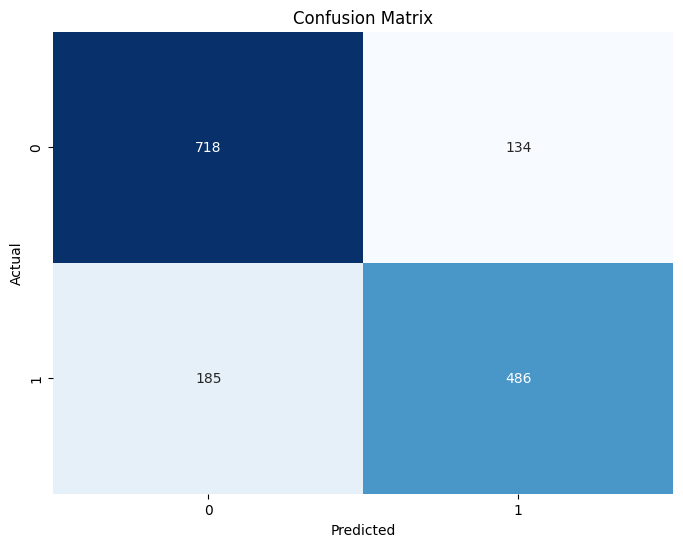

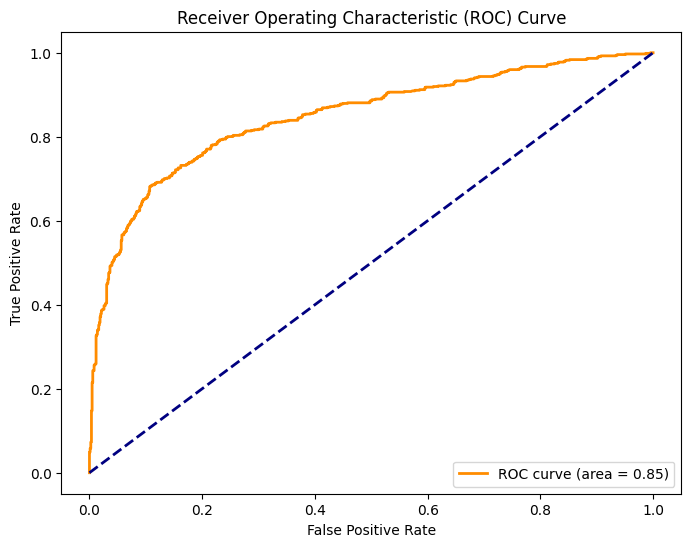

In [130]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Generate predictions on the test set
X_test_cv = tfidf.transform(X_test)
test_predictions = clf.predict(X_test_cv)

# Plot confusion matrix
plot_confusion_matrix(y_val, predictions)

# Plot ROC curve
y_val_probs = clf.decision_function(X_val_cv)
plot_roc_curve(y_val, y_val_probs)

In [131]:
# Preparing submission

# transform X_test using CV
X_test_cv = tfidf.transform(X_test)

# generate predictions
predictions = clf.predict(X_test_cv)
predictions

array([1, 0, 1, ..., 1, 1, 1])

In [132]:
predicted_df = df_test.copy()
predicted_df['target'] = predictions

In [133]:
predicted_df

,text,target
0,KEYWORD= NaN; LOCATION= NaN; TEXT= happened te...,1
1,KEYWORD= NaN; LOCATION= NaN; TEXT= heard earth...,0
2,KEYWORD= NaN; LOCATION= NaN; TEXT= forest fire...,1
3,KEYWORD= NaN; LOCATION= NaN; TEXT= apocalypse ...,1
4,KEYWORD= NaN; LOCATION= NaN; TEXT= typhoon sou...,1
...,...,...
3258,KEYWORD= NaN; LOCATION= NaN; TEXT= earthquake ...,1
3259,KEYWORD= NaN; LOCATION= NaN; TEXT= storm ri wo...,1
3260,KEYWORD= NaN; LOCATION= NaN; TEXT= green line ...,1
3261,KEYWORD= NaN; LOCATION= NaN; TEXT= meg issue h...,1


In [134]:
submission_df = pd.read_csv(f'../Data/sample_submission.csv')
submission = pd.DataFrame({"id": submission_df['id'],
            "target":predictions})
submission.to_csv('submission.csv', index=False)